![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import collections
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import warnings; warnings.simplefilter('ignore')

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

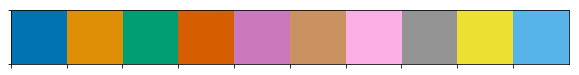

In [4]:
# цветовая палитра для диаграмм seaborn
sns.palplot(sns.color_palette('colorblind'))

In [5]:
# Функция для расчета и визуализации границ выбросов.

def show_IQR(pd_dataset, column_name, bins_n=10):

#        Вспомогательная функция для расчета и визуализации границ выбросов.
#        на входе датасет, наименование столбца (признака) и количество столбиков гистограмы
       
#        Выводит расчитанные параметры квантилей и гистограммы распределения и boxplot

    data_column = pd_dataset[column_name]
    perc_25 = data_column.quantile(0.25, interpolation="midpoint")
    perc_75 = data_column.quantile(0.75, interpolation="midpoint")
    IQR = perc_75 - perc_25
    print(f'Q1: {perc_25}\nQ3: {perc_75}\nIQR: {IQR}',
          f'\nГраница выбросов: [{perc_25 - 1.5*IQR}, {perc_75 + 1.5*IQR}]')
    
    # гистограмма распределения: 
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    sns.distplot(data_column.values, bins=bins_n)
    plt.title(column_name + ' Distribution\n', fontsize=15)
    plt.xlabel(column_name)
    plt.ylabel('Quantity (frequency)')

    # boxplot: 
    plt.subplot(122)
    sns.boxplot(data_column.values)
    plt.title(column_name + ' Distribution\n', fontsize=15)
    plt.xlabel(column_name)
    return 0

# DATA

In [6]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [8]:
df_train.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
37226,id_3494,Rome,"['Italian', 'Mediterranean']",3495.0,4.0,$$ - $$$,117.0,"[['Good but not great', 'authentic, fresh food...",/Restaurant_Review-g187791-d1012596-Reviews-Al...,d1012596
35940,id_1951,Lisbon,"['International', 'Mediterranean', 'European',...",1954.0,4.0,$$ - $$$,29.0,"[['Great City Hotel', 'Amazing breakfast'], ['...",/Restaurant_Review-g189158-d8853092-Reviews-Do...,d8853092
1658,id_1393,Lisbon,NaN,1394.0,4.5,NaN,7.0,"[['My favorite spot in Lisbon', 'Excellent cho...",/Restaurant_Review-g189158-d13126863-Reviews-A...,d13126863
2117,id_206,Lyon,"['French', 'European']",207.0,4.5,$$ - $$$,204.0,"[['Very nice dinner with friendly service', 'E...",/Restaurant_Review-g187265-d2251696-Reviews-La...,d2251696
9935,id_3482,Paris,"['Polish', 'European', 'Eastern European', 'Ce...",3483.0,4.5,$$ - $$$,66.0,"[['Very traditional, solid Polish food', 'Char...",/Restaurant_Review-g187147-d815214-Reviews-Maz...,d815214


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [10]:
df_test.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
9923,id_9923,Milan,"['Steakhouse', 'Italian', 'British', 'Pub']",1360.0,$$ - $$$,410.0,"[['Good Beers, Good Food', 'If you are in the ...",/Restaurant_Review-g187849-d6950498-Reviews-Sl...,d6950498
3043,id_3043,Budapest,NaN,120.0,NaN,246.0,"[['Gourmet Cocktail Bar..', 'We got drunk ther...",/Restaurant_Review-g274887-d1580627-Reviews-Bo...,d1580627
7124,id_7124,Berlin,"['Mediterranean', 'European', 'Spanish', 'Vege...",903.0,$$ - $$$,79.0,"[['Place to go Basque in Berlin', 'Basques tap...",/Restaurant_Review-g187323-d4777064-Reviews-Tx...,d4777064
1667,id_1667,Budapest,['Fast Food'],1540.0,$,38.0,"[['Neat Place', 'Quick and tasty snack'], ['10...",/Restaurant_Review-g274887-d7705058-Reviews-Ho...,d7705058
4253,id_4253,London,NaN,10862.0,NaN,5.0,"[['Very lovely food', 'Why no cash?'], ['10/23...",/Restaurant_Review-g186338-d12621189-Reviews-G...,d12621189


In [11]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [13]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [15]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
29391,id_959,Oslo,"['Bar', 'Cafe', 'Pub']",960.0,NaN,4.0,"[['Great location'], ['02/13/2017']]",/Restaurant_Review-g190479-d8132550-Reviews-Ma...,d8132550,1,4.0
18846,id_4680,Paris,['Pub'],4681.0,$$ - $$$,88.0,"[['Cracking little find.', 'Great live music o...",/Restaurant_Review-g187147-d782430-Reviews-Le_...,d782430,1,4.0
16072,id_2158,Budapest,NaN,2159.0,NaN,7.0,"[['Cold Staropramen', 'Awesome atmosphere'], [...",/Restaurant_Review-g274887-d11912843-Reviews-F...,d11912843,1,3.0
13660,id_15485,London,NaN,15497.0,NaN,5.0,"[['only stayed 30 mins', 'Fantastic & tasty'],...",/Restaurant_Review-g186338-d10754220-Reviews-D...,d10754220,1,2.5
17908,id_2499,London,"['Bar', 'European', 'British', 'Vegetarian Fri...",2504.0,$$ - $$$,257.0,[['Powder Keg re-invented as Mediterranean sm....,/Restaurant_Review-g186338-d2419862-Reviews-Po...,d2419862,1,4.5


In [16]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [17]:
# Кол-во пропусков, которые есть в предоставленных данных

data.isnull().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64

### Исcледуем 'Restaurant_id'
Видна зависимость между данным признаком и признаком ranking. Посмотрим на корреляцию.

In [18]:
# Уберем первые не числовые три символа 'id_'
data['Restaurant_id'] = data['Restaurant_id'].apply(lambda x: float(x[3:]))

In [19]:
data[['Restaurant_id', 'Ranking']].corr()

,Restaurant_id,Ranking
Restaurant_id,1.00000,0.82509
Ranking,0.82509,1.00000


Коэффициент корреаляции 0.82
Есть корреляция.

### Исcледуем 'City'

In [20]:
data['City'].describe()

count      50000
unique        31
top       London
freq        7193
Name: City, dtype: object

In [21]:
data['City'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

В столбце 'City' нет пропусков.
31 уникальный город.
Сам по себе признак 'City' идеально подходит что-бы сделать из него dummies-переменную.
Ниже создадим дополнительные признаки на основе города.

### Исcледуем 'Number of Reviews'

In [22]:
data['Number of Reviews'].describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

In [23]:
data['Number of Reviews'].isnull().sum()

3200

Отсутствие данных в столбце может оказаться критичным для модели.
Вынесем все пропуски в отдельный признак. 
Пропуски заполним нулем.

In [24]:
data['number_of_rev_is_NAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [25]:
data['Number of Reviews'].fillna(0, inplace=True)

Q1: 7.0
Q3: 105.0
IQR: 98.0 
Граница выбросов: [-140.0, 252.0]


0

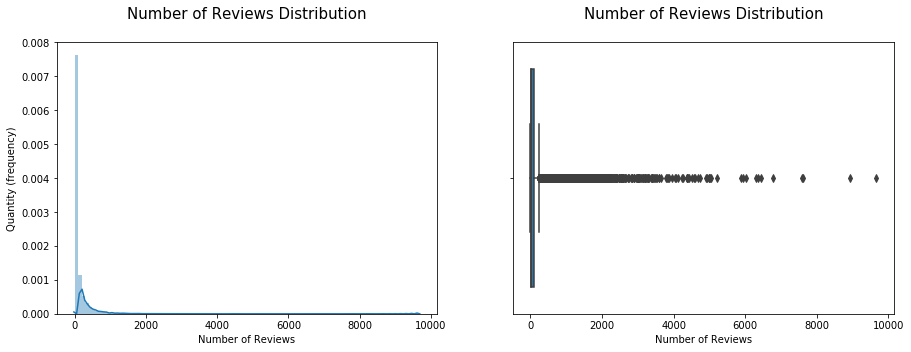

In [26]:
# Есть ли выбросы

show_IQR(data, 'Number of Reviews', 100)

Сколько значений у нас выбивается больше, чем 252.

In [27]:
sum(data['Number of Reviews'] > 252)

5946

За верхнюю границу выбросов выходит много значений, но на гистограмме распределения видно, что распределение смещено вправо и содержит очень длинный хвост, при чем, больше 2000 практически нет данных. Посмотрим, сколько значений в массиве содержит более 2000 отзывов:

In [28]:
sum(data['Number of Reviews'] > 2000)

171

171 значение заменим их на 2000

In [29]:
data['Number of Reviews'] = data['Number of Reviews'].apply(lambda x: 2000 if x > 2000 else x)

In [30]:
# Проверим результат

data['Number of Reviews'].describe()

count    50000.000000
mean       112.523920
std        236.929092
min          0.000000
25%          7.000000
50%         28.000000
75%        105.000000
max       2000.000000
Name: Number of Reviews, dtype: float64

### Исcледуем 'Price Range'

In [31]:
# Количество пропусков:

sum(data['Price Range'].isnull())

17361

In [32]:
# Уникальные значения

data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

Много пропусов. 
Больше всего ресторанов в среднем ценовом сегменте. 
Вынесем пропуски в отдельный признак. 
Пропуски заменим на наиболее частое значение: 2.

In [33]:
price = {'$' : 1, '$$ - $$$' : 2, '$$$$' : 3}
data['Price Range'] = data['Price Range'].map(price)
data['price_range_is_NAN'] = pd.isna(data['Price Range']).astype('uint8')
data['Price Range'] = data['Price Range'].fillna(2)

In [34]:
data['Price Range'].describe()

count    50000.000000
mean         1.879320
std          0.421189
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: Price Range, dtype: float64

In [35]:
# Проверим результат
data['Price Range'].value_counts()

2.0    40402
1.0     7816
3.0     1782
Name: Price Range, dtype: int64

### Исcледуем 'ID_TA'

In [36]:
data['ID_TA'].value_counts()

d11921719    2
d1568045     2
d697406      2
d7342803     2
d4600226     2
            ..
d3393854     1
d1355049     1
d1991709     1
d4736414     1
d9467751     1
Name: ID_TA, Length: 49963, dtype: int64

Есть рестораны с одним и тем же идентификатором в системе (возможно, это сетевые рестораны или филиалы или дубли).
Посмотрим подробнее.

In [37]:
# Сколько таких ресторанов

sum(data['ID_TA'].value_counts() > 1)

37

Вернуться к колонке rest_id, есть ли там дважды встречающиеся значения.



In [38]:
data['Restaurant_id'].value_counts()

871.0      19
227.0      19
436.0      19
633.0      19
344.0      18
           ..
11420.0     1
6603.0      1
8793.0      1
5548.0      1
11783.0     1
Name: Restaurant_id, Length: 13094, dtype: int64

In [39]:
sum(data['Restaurant_id'].value_counts() >= 2)

9287

Restaurant_id можно предположить, что это сеть ресторанов. 
Мы можем создать признак, который бы указывал, является ли ресторан частью сети или нет. 

В ситуации с id_ta может быть это некая компания, которая владеет несколькими разными 
ресторанами. 

Отфильтруем эти значения и посмотрим на них повнимательнее.

In [40]:
data['Restaurant_id'].nunique()

13094

In [41]:
data_id_ta_notunique = data[data['ID_TA'].map(data['ID_TA'].value_counts()) > 1]

In [42]:
data_id_ta_notunique['ID_TA'] = data_id_ta_notunique['ID_TA'].apply(lambda x: int(x[1:]))

In [43]:
data_id_ta_notunique['ID_TA'].value_counts()

987900      2
10316215    2
1235635     2
4748208     2
10440367    2
11698990    2
1568045     2
4914988     2
13002276    2
4600226     2
12488993    2
7337366     2
3748757     2
1028622     2
9877640     2
1315077     2
5617412     2
697406      2
7809594     2
2010743     2
7827387     2
10047799    2
2669414     2
3161682     2
2360290     2
11674463    2
2477531     2
5618007     2
11921719    2
11999956    2
7342803     2
793170      2
3396817     2
8753348     2
3685055     2
3647024     2
9802625     2
Name: ID_TA, dtype: int64

In [44]:
# Пара таких ресторанов

data_id_ta_notunique.query('ID_TA == 987900')

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,number_of_rev_is_NAN,price_range_is_NAN
18019,2361.0,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...",2363.0,2.0,190.0,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,987900,1,4.0,0,0
32998,2312.0,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...",2314.0,2.0,190.0,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,987900,1,4.0,0,0


В наборе данныз дублируется 37 ресторанов. 

Т.к. по условиям задачи удалять строки из датасета нельзя, то ничего не меняем.

Возможно, в последствии, id_ta удалим за ненадобностью, но для порядка уберем символ d в начале и приведем к числовому значению. 

Возможно, ID_TA будет не лишним для модели, т.к. рестораны, которые зарегистрировались раньше получаю и меньший ID, возможно, такие рестораны уделяют больше внимания рейтингу.

In [45]:
data['ID_TA'] = data['ID_TA'].apply(lambda x: int(x[1:]))

### Исcледуем 'URL_TA'

In [46]:
data.loc[data['URL_TA'][0]:5]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,number_of_rev_is_NAN,price_range_is_NAN
0,0.0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,10746918,0,0.0,0,0
1,1.0,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,6674944,0,0.0,0,0
2,2.0,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,13129638,0,0.0,0,0
3,3.0,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,680417,0,0.0,0,0
4,4.0,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,1112354,0,0.0,0,0
5,5.0,Paris,"['French', 'Cafe', 'Fast Food']",5093.0,1.0,24.0,"[['Lunch Break', 'Good to Quick Bite'], ['09/0...",/Restaurant_Review-g187147-d8458643-Reviews-Le...,8458643,0,0.0,0,0


In [47]:
data['URL_TA'][0]

'/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html'

In [48]:
data['URL_TA'][1]

'/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html'

url ресторана состоит из двух закодированных величин. 

Первая, судя по совпадениям, означает город, вторая совпадает с id_ta. 

Не ясно, зачем нам может понадобиться код города. 
Возможно, имеет смысл вместо города из столбца City использовать код, но пока в этом нет необходимости.

### Исcледуем 'Cuisine Style'

In [49]:
type(data['Cuisine Style'][0])

str

In [50]:
data['Cuisine Style'].isnull().sum()

11590

Строковый тип.
11590 пустых значений. 

Вынесем их в отдельный признак. 
Пустые значения в типе кухни заменим на значение "Unknown".

In [51]:
# Заполним пропуски значением 'Other':

data['Cuisine Style'] = data['Cuisine Style'].fillna('Other')

In [52]:
# Превратим перечисление кухонь в список:

for i in ['\'', '[', ']']:
    data['Cuisine Style'] = data['Cuisine Style'].apply(
        lambda x: x.replace(i, ''))

data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: x.split(', '))

In [53]:
# Посмотрим сколько всего получилось кухонь:

Cusines_count = data['Cuisine Style'].explode().value_counts()

display(Cusines_count)

Vegetarian Friendly    14021
European               12561
Other                  11590
Mediterranean           7820
Italian                 7433
                       ...  
Polynesian                 2
Burmese                    1
Latvian                    1
Salvadoran                 1
Xinjiang                   1
Name: Cuisine Style, Length: 126, dtype: int64

In [54]:
# 126 типов кухонь, некоторые из которых встречаются всего несколько раз, это слишком много.
# Составим список самых редких кухонь (первый квартиль списка кухонь):

not_pop_cousine = []

for i in range(len(Cusines_count)):
    if Cusines_count[i] < Cusines_count.quantile(0.25):
        not_pop_cousine.append(Cusines_count.index[i])

In [55]:
# Заменим все редкие кухни на 'Other' и, если в одном ресторане станет несколько кухонь с одинаковым значением,
# объединим их в одну:

def replace_cousines(cousines):
    for i in range(len(cousines)):
        if cousines[i] in not_pop_cousine:
            cousines[i] = 'Other'
    return list(set(cousines))

data['Cuisine Style'] = data['Cuisine Style'].apply(replace_cousines)

### Исследуем 'Reviews'

In [56]:
data['Reviews'].isnull().sum()

2

In [57]:
data['Reviews'].value_counts()

[[], []]                                                                                                                              8112
[['Very cozy!', 'Service rate: 1'], ['01/17/2016', '11/18/2015']]                                                                        2
[['Excellent cuisine, friendly and helpful se...', 'Not tasty'], ['12/25/2016', '06/05/2016']]                                           2
[['Fantastic food, Excellent service', 'Surprising good Indian food in Spain'], ['01/07/2018', '11/08/2017']]                            2
[['Whenever in Madrid, we never miss this gem...', 'Underrated sushi restaurant with very good...'], ['04/11/2017', '12/02/2016']]       2
                                                                                                                                      ... 
[['Sooo good!', 'The place to be!'], ['11/11/2017', '04/29/2016']]                                                                       1
[['Excellent cocktails', 'F

Признак Reviews состоит из текстового отзыва и даты. 

Есть два пропуска явных и 8112 пропусков не явных, не имеющих внутри ничего кроме скобок. Отсутствие отзыва может быть важным для модели. 

Вынесем все отзывы в отдельных признак.

In [58]:
data['review_is_NAN'] = (data['Reviews'] == '[[], []]').astype('uint8')

In [59]:
data['review_is_NAN'] = pd.isna(data['Reviews']).astype('uint8')

In [60]:
# Выделим дату отзыва.
data['date_of_review'] = data['Reviews'].apply(
    lambda x: [0] if pd.isna(x) else x[2:-2].split('], [')[1][1:-1].split("', '"))

In [61]:
# Добавим признак кол-ва дней между отзывами.
data['days_between_reviews'] = data.date_of_review.apply(lambda x: None if x == [] 
                                                         else pd.to_datetime(x).max() - pd.to_datetime(x).min())

In [62]:
# посмторим на показатели

data.days_between_reviews.describe()

count                       41888
mean     123 days 05:05:55.462184
std      212 days 14:08:22.315988
min               0 days 00:00:00
25%               8 days 00:00:00
50%              49 days 00:00:00
75%             148 days 00:00:00
max            3296 days 00:00:00
Name: days_between_reviews, dtype: object

Максимальный интервал между отзывами: 3296 дней. 

Переведем значения в числа и посмотрим выбросы.

In [63]:
data['days_between_reviews'] = data['days_between_reviews'].apply(lambda x: x.days)

Q1: 8.0
Q3: 148.0
IQR: 140.0 
Граница выбросов: [-202.0, 358.0]


0

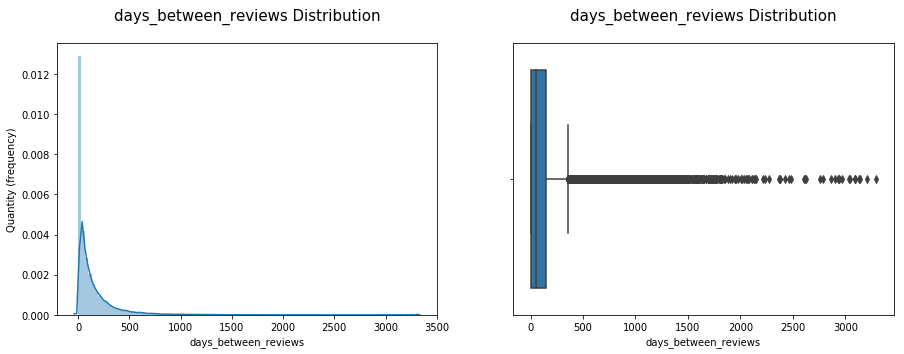

In [64]:
# посмотрим распределение и возможные выбросы

show_IQR(data, 'days_between_reviews', 100)

In [65]:
len(data.query('days_between_reviews > 365'))

3393

Между отзывами прошло больше года в 3393-х случаях. 

У распределения очень длинный хвост вправо - падает практически до нуля при значениях больше 1000.

Имеет смысл больше трёх лет (1095 дней) не учитывать отдельно, а добавить к трёхлетним значениям.

In [66]:
len(data.query('days_between_reviews > 1095'))

385

In [67]:
data.days_between_reviews = data.days_between_reviews.apply(lambda x: 1095 if x > 1095 else x)

In [68]:
data.days_between_reviews.isnull().sum()

8112

In [69]:
data.days_between_reviews.describe()

count    41888.000000
mean       119.478180
std        185.985765
min          0.000000
25%          8.000000
50%         49.000000
75%        148.000000
max       1095.000000
Name: days_between_reviews, dtype: float64

Заполним пропуски медианой.

In [70]:
data.days_between_reviews = data.days_between_reviews.fillna(data.days_between_reviews.median())

In [71]:
# Проверим
data.days_between_reviews.isnull().sum()

0

Добавим еще один признак - кол-во дней с последнего отзыва до настоящего момента.

In [72]:
data['days_tillnow'] = data.date_of_review.apply(
    lambda x: None if x == [] else datetime.now() - pd.to_datetime(x).max())

In [73]:
data.days_tillnow.isnull().sum()

8112

In [74]:
# Заменим пропуски на среднее
data.days_tillnow = data.days_tillnow.fillna(data.days_tillnow.mean())

### Посмотрим распределение признака

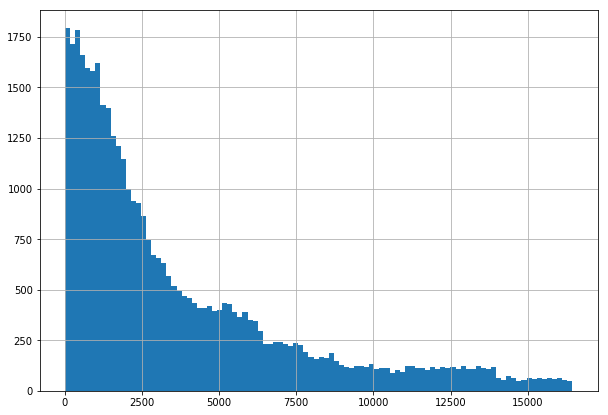

In [75]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

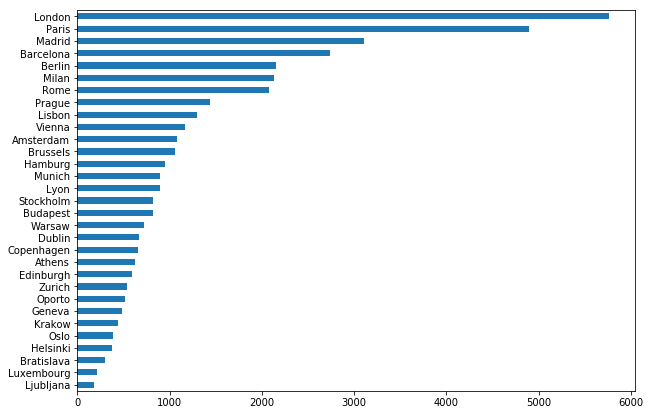

In [76]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

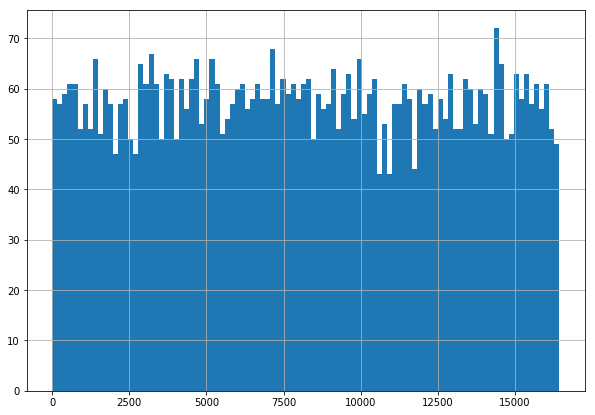

In [77]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

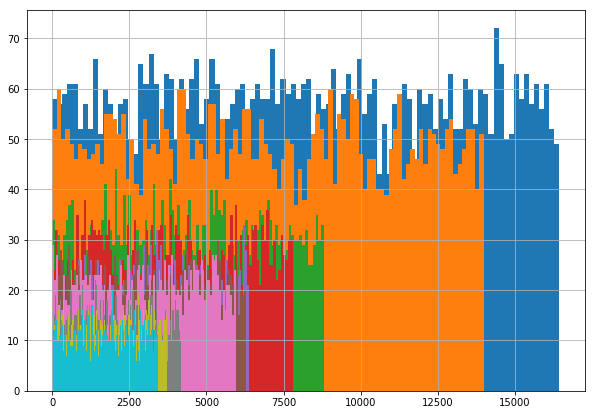

In [78]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

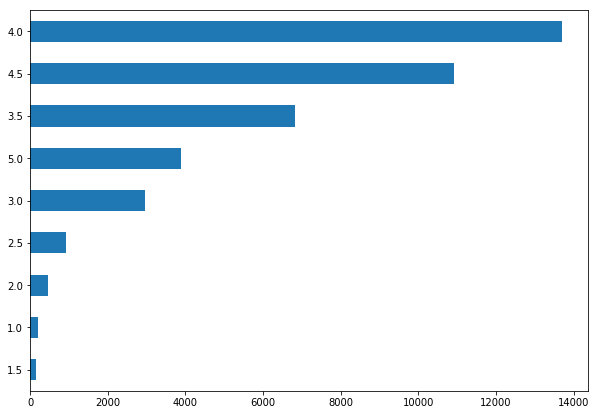

In [79]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

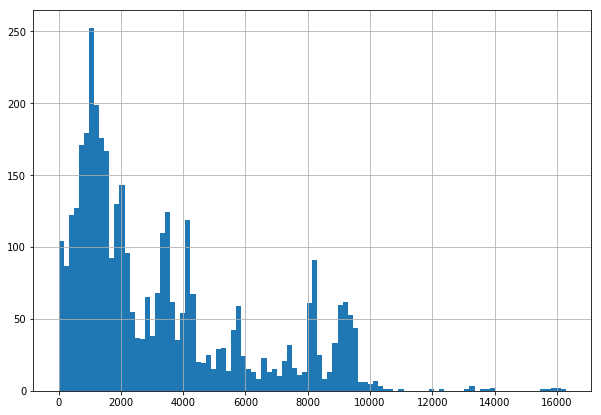

In [80]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

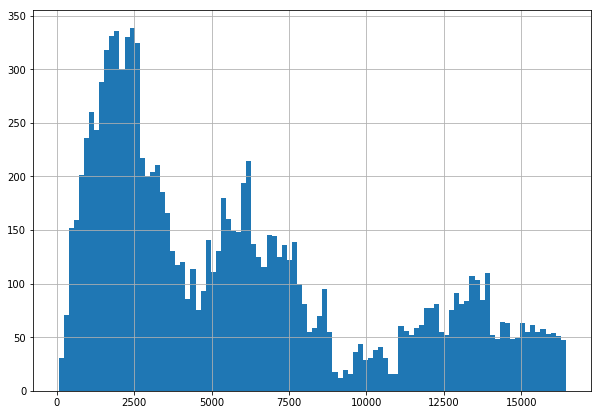

In [81]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

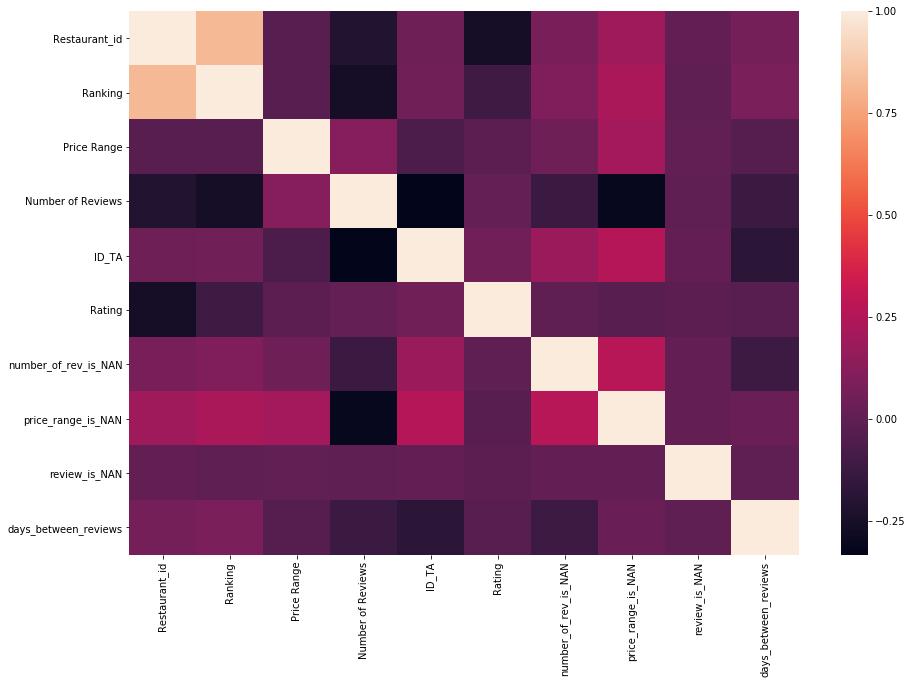

In [82]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Добавим несколько признаков, которые могут улучшить работу нашей модели.

In [83]:
# Добавим признак - численность население (по данным из Википедии)

population = {
    'London' : 8909081,
    'Paris' : 2148271,
    'Madrid' : 3223334,
    'Barcelona' : 1620343,
    'Berlin' : 3769495,
    'Milan' : 1399860,
    'Rome' : 2860009,
    'Prague' : 1324277,
    'Lisbon' : 505526,
    'Vienna' : 2600000,
    'Amsterdam' : 872680,
    'Brussels' : 1208542,
    'Hamburg' : 1845229,
    'Munich' : 1484226,
    'Lyon' : 516092,
    'Stockholm' : 975904,
    'Budapest' : 1752286,
    'Warsaw' : 1793579,
    'Dublin' : 554554,
    'Copenhagen' : 794128,
    'Athens' : 664046,
    'Edinburgh' : 488050, 
    'Zurich' : 415215,
    'Oporto' : 287591,
    'Geneva' : 201818, 
    'Krakow' : 779115, 
    'Oslo' : 697549, 
    'Helsinki' : 656229,
    'Bratislava' : 437726,
    'Luxembourg' : 626108,
    'Ljubljana' : 295504
}

data['Population'] = data['City'].map(population)

In [84]:
# Используем сторонний справочник количества ресторанов в городах
res_count = {
    'Paris': 17593,
    'Stockholm': 3131,
    'London': 22366,
    'Berlin': 8110, 
    'Munich': 3367,
    'Oporto': 2060, 
    'Milan': 7940,
    'Bratislava': 1331,
    'Vienna': 4387, 
    'Rome': 12086,
    'Barcelona': 10086,
    'Madrid': 11562,
    'Dublin': 2706,
    'Brussels': 3703,
    'Zurich': 1901,
    'Warsaw': 3210,
    'Budapest': 3445, 
    'Copenhagen': 2637,
    'Amsterdam': 4189,
    'Lyon': 2833,
    'Hamburg': 3501, 
    'Lisbon': 4985,
    'Prague': 5850,
    'Oslo': 1441, 
    'Helsinki': 1661,
    'Edinburgh': 2248,
    'Geneva': 1753,
    'Ljubljana': 647,
    'Athens': 2814,
    'Luxembourg': 759,
    'Krakow': 1832       
}
# Создадим новый признак 'Restaurants Count', отражающий общее количество ресторанов в городе, в котором расположен данный ресторан
data['Restaurants Count'] = data['City'].map(res_count)

In [85]:
# Добавим признак - индекс покупательской способности согласно рейтингу Numbeo (2018)

purchasing_power_index = {
    'London' : 24,
    'Paris' : 22,
    'Madrid' : 23,
    'Barcelona' : 30,
    'Berlin' : 8,
    'Milan' : 40,
    'Rome' : 37,
    'Prague' : 31,
    'Lisbon' : 48,
    'Vienna' : 21,
    'Amsterdam' : 19,
    'Brussels' : 15,
    'Hamburg' : 7,
    'Munich' : 6,
    'Lyon' : 70,
    'Stockholm' : 13,
    'Budapest' : 51,
    'Warsaw' : 29,
    'Dublin' : 27,
    'Copenhagen' : 10,
    'Athens' : 53,
    'Edinburgh' : 16, 
    'Zurich' : 2,
    'Oporto' : 42,
    'Geneva' : 3, 
    'Krakow' : 36, 
    'Oslo' : 17, 
    'Helsinki' : 9,
    'Bratislava' : 39,
    'Luxembourg' : 4,
    'Ljubljana' : 32
}

data['purchasing_power'] = data['City'].map(purchasing_power_index)

In [86]:
# Добавим признак - является ли город столицей (1 - да, 0 - нет)

capital = ['London', 'Paris', 'Madrid', 'Berlin', 'Rome', 'Prague',
          'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 'Stockholm',
          'Budapest', 'Warsaw', 'Dublin', 'Copenhagen', 'Athens',
          'Edinburgh', 'Oslo', 'Helsinki', 'Bratislava',
          'Luxembourg', 'Ljubljana']
data['is_capital'] = data['City'].apply(lambda x: 1 if x in capital else 0)

In [87]:
# Добавим признак кол-ва ресторанов в городе

number_of_rest_city = data.groupby('City')['Ranking'].count().to_dict()
data['rest_city_count'] = data['City'].map(number_of_rest_city)

In [88]:
# Добавим признак относительного ранга ресторана по городу

data['city_ranking'] = data['Ranking'] / data.rest_city_count

In [89]:
# Добавим числовой признак 'Population Per Restaurant' = 'Population' / 'Restaurants Count'
data['Population Per Restaurant'] = data['Population'] / data['Restaurants Count']

Смотрим далее

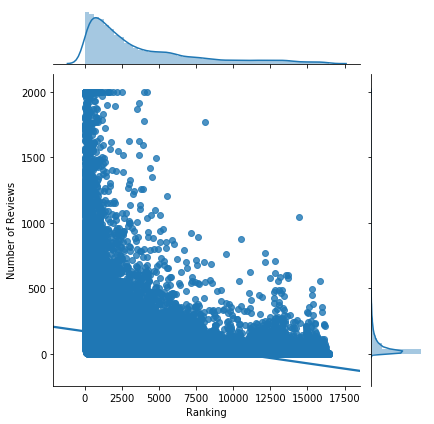

In [90]:
sns.jointplot(x = 'Ranking', y = 'Number of Reviews', data = data, kind = 'reg')

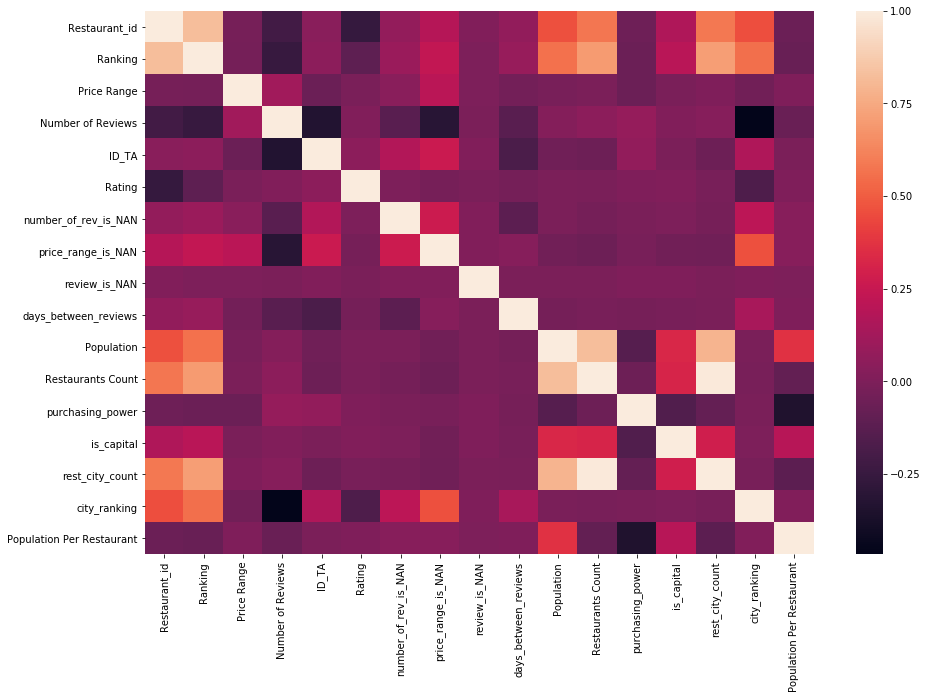

In [91]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Добавим признаки:

ранг ресторана на основании кол-ва отзывов
соотношение кол-ва отзывов и населения города

In [92]:
# ранг ресторана на основании кол-ва отзывов

data['ranking_rev_count'] = data['Ranking'] * data['Number of Reviews']

In [93]:
# соотношение кол-ва отзывов и населения города

data['reviews_per_city_pop'] = data['Number of Reviews'] / data['Population']

In [94]:
# Признак среднее кол-во отзывов в городе

mean_rev_per_city = data.groupby('City')['Number of Reviews'].mean()
mean_rev_per_city = mean_rev_per_city.apply(lambda x: round(x, 2))
data['mean_rev_per_city'] = data['City'].map(mean_rev_per_city)

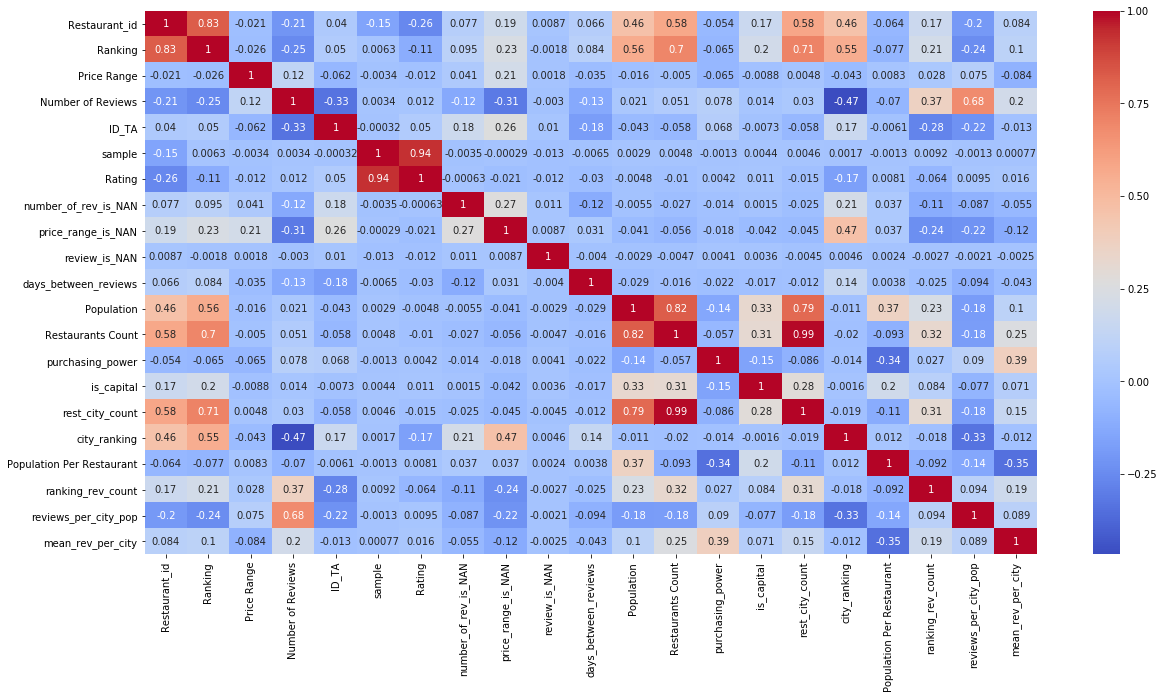

In [95]:
fig, ax = plt.subplots(1,1, figsize = (20,10))
ax = sns.heatmap(data.corr(),annot = True, cmap = 'coolwarm')

In [96]:
# Добавим признак туристическая привлекательность.
# Место города в рейтинге топ-100 городов посещения в 2018 году (так как датасет устаревший)
# Источник - Euromonitor international

# Так как не все города входят в топ-100, то города делим на группы:
# 1 - место 1-25
# 2 - место 26-50
# 3 - место 51-75
# 4 - место 76-100
# 5 - место выше 100

tourist_attract = {
    'London' : 1,
    'Paris' : 1,
    'Madrid' : 2,
    'Barcelona' : 2,
    'Berlin' : 2,
    'Milan' : 5,
    'Rome' : 1,
    'Prague' : 1,
    'Lisbon' : 3,
    'Vienna' : 2,
    'Amsterdam' : 1,
    'Brussels' : 3,
    'Hamburg' : 5,
    'Munich' : 3,
    'Lyon' : 5,
    'Stockholm' : 4,
    'Budapest' : 3,
    'Warsaw' : 3,
    'Dublin' : 5,
    'Copenhagen' : 3,
    'Athens' : 2,
    'Edinburgh' : 5, 
    'Zurich' : 5,
    'Oporto' : 4,
    'Geneva' : 5, 
    'Krakow' : 3, 
    'Oslo' : 5, 
    'Helsinki' : 5,
    'Bratislava' : 5,
    'Luxembourg' : 5,
    'Ljubljana' : 5
}

data['tourist_attract'] = data['City'].map(tourist_attract)

In [97]:
# Максимальный ранг

ranking_max_per_city = data.groupby('City')['Ranking'].max()
data['rating_max_per_city'] = data['City'].map(ranking_max_per_city)

In [98]:
# Применим признаки
data = pd.get_dummies(data, columns=['City'], dummy_na=True)

## Data Preprocessing

In [99]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [100]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
        # убираем не нужные для модели признаки
    df_output.drop(['ID_TA',], axis = 1, inplace=True)
    
    
    # добавляем признаки
    # учитываем отсутствие отзывов (Number of Reviews)
    df_output['Number_of_Reviews_is_NAN'] = pd.isna(df_output['Number of Reviews']).astype('uint8')
    # учитываем отсутствие видов кухни (Cuisine Style)
    df_output['Cuisine_Style_is_NAN'] = pd.isna(df_output['Cuisine Style']).astype('uint8')
    # учитываем отсутствие ценовой категории (Price Range)
    data['Price_Range_is_NaN'] = pd.isna(data['Price Range']).astype('float64') 
    
    
    
    # ################### 2. NAN ############################################################## 
    
    # Далее заполняем пропуски отзывов на ноль
    df_output['Number of Reviews'].fillna(df_output.groupby('City')['Number of Reviews'].transform('median'), inplace=True)
        # После замены пропусков на ноль добавляем столбец нормализации отзывов
    #df_output['Number_of_Reviews_norm']=(df_output['Number of Reviews']-df_output['Number of Reviews'].min())/(df_output['Number of Reviews'].max()-df_output['Number of Reviews'].min())  
    
    
    # считаем количество кухонь на ресторан
    df_output['Cuisine_count'] = df_output['Cuisine Style'].dropna().apply(lambda name: len(name.split(',')))
    # вместо отсутсвующих значений ставим медианное по городу
    df_output.Cuisine_count.fillna(df_output.groupby('City').Cuisine_count.transform('median'), inplace=True)
      
    
    # функция расчета дней между отзывами. Если нет отзывов потом заполним соедним количеством дней
    def data_diff(row):
        try:
            return abs(row[1] - row[0]).days
        except:
            return None
    # Функция вычленяем первую дату отзыва. 
    # По некторым ресторанам только один отзыв
    def data_convert(string):
        try:
            return pd.to_datetime(string.split(',')[-2].strip(r" ']["))
        except:
            return pd.to_datetime(string.split(',')[-1].strip(r" ']["))
    # Создаем признак количества дней между отзывами 
    df_output['Review_date_last'] = df_output['Reviews'].apply(lambda name: pd.to_datetime(str(name).split(",")[-1].strip(r" '][")))
    df_output['Review_date_first'] = df_output['Reviews'].apply(lambda name: data_convert(str(name)))
    df_output['Days'] = df_output[['Review_date_last','Review_date_first']].apply(lambda row: data_diff(row), axis=1)
    # Заполняем пропуски
    df_output['Days'] = df_output['Days'].fillna(df_output['Days'].mean())
    # Создаем признак количества дней c последнего отзыва до сегодняшнего дня
    df_output['Days_to_today'] = df_output['Review_date_last'].apply(lambda days: (pd.to_datetime('today') - days).days)
    df_output['Days_to_today'].fillna(df_output.groupby('City')['Days_to_today'].transform('median'), inplace=True)
    
    
    # функция для подсчета положительных отзывов.
    def good_response(row):
        words_count = 0
        good_words_list = ['good', 'wonderful', 'great', 'best', 'excellent', 'perfect', 'awesome', 'nice', 'fantastic',
                           'delicious', 'tasty', 'amazing', 'fine', 'wow', 'favorite', 'fabulous', 'lovely', 'cosy',
                           'decent', 'beautiful', 'surpris']
    # добавляем признакт с посчетом количества положительных слов
    df_output['Good_words_count'] = df_output.Reviews.apply(lambda row: good_response(str(row).split('], [')[0]))
    
    # добавляем признак столица город или нет. делаем это до get_dummies городов City
    all_cities = df_output.City.value_counts()  
    capitals = ['London', 'Paris', 'Madrid', 'Berlin', 'Rome', 'Prague', 'Lisbon', 'Amsterdam',
                'Brussels', 'Stockholm', 'Budapest', 'Warsaw', 'Copenhagen', 'Athens', 'Zurich', 
                'Oslo', 'Helsinki', 'Bratislava', 'Luxembourg']
    capitals_dict = dict([(x, int(x in capitals)) for x in all_cities.index])
    df_output['is_capital'] = df_output.City.apply(lambda x: capitals_dict[x])
    
    
    #создаю словарь, где помечаю количество ресторанов с одинаковыми id
    count_chain_restaurants = dict(df_output.Restaurant_id.value_counts())

    #создаю функцию, с помощью которой помечаю сетевые рестораны
    def chain_restaurants(x):
        if count_chain_restaurants[x] > 1:
            return 1
        else:
            return 0
    
    df_output['chain restaurants'] = df_output['Restaurant_id'].apply(chain_restaurants)
    
    # создание признака"Количество ресторанов в городе"
    # создаю словарь с количеством ресторанов для каждого города
    restaurants_in_city = {}
    for City in df_output['City'].unique():
        restaurants_in_city.setdefault(City, len(df_output[df_output["City"] == City]))
    #создаю новый признак с помощью словаря
    df_output['count_restaurants_in_city'] = df_output['City'].apply(lambda x: restaurants_in_city[x])
    
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    
    # обрабатываем Price Range. 
    # заполним значения в переменной по словарю
    dic_value_Price = {'$':1,'$$ - $$$':2,'$$$$':3}
    df_output['Price_Range'] = df_output['Price Range'].map(lambda x: dic_value_Price.get(x,x))
    # Большинство ресторанов со средней ценой - заполняем пропуски двойкой (2)
    df_output['Price_Range'] = df_output['Price_Range'].fillna(2)
    
    
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    
   
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object' or df_output[s].dtypes == 'datetime64[ns]']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

Запускаем и проверяем что получилось

In [101]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Number of Reviews,sample,Rating,Number_of_Reviews_is_NAN,Cuisine_Style_is_NAN,Cuisine_count,Days,Days_to_today,is_capital,...,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Price_Range
41053,2728.0,3.0,1,4.5,0,0,2.0,123.993124,1452.5,1,...,0,0,1,0,0,0,0,0,0,2.0
38330,442.0,55.0,1,4.5,0,0,2.0,309.000000,2516.0,0,...,0,0,0,0,0,0,0,0,0,2.0
3749,14791.0,38.0,0,0.0,1,1,3.0,0.000000,1249.0,1,...,0,0,0,0,0,0,0,0,0,2.0
25733,1241.0,10.0,1,4.5,0,1,3.0,0.000000,1941.0,0,...,0,0,0,0,0,0,0,0,0,2.0
8009,779.0,30.5,0,0.0,1,0,2.0,123.993124,1491.0,0,...,0,0,0,0,0,0,0,0,0,2.0
46106,2410.0,6.0,1,4.5,0,0,3.0,8.000000,2236.0,1,...,0,0,0,0,0,0,0,0,0,2.0
20805,481.0,40.0,1,4.5,0,0,5.0,64.000000,1421.0,1,...,0,0,0,0,0,0,0,1,0,2.0
18144,100.0,542.0,1,4.5,0,0,5.0,8.000000,1250.0,1,...,0,0,0,1,0,0,0,0,0,1.0
15394,873.0,63.0,1,4.5,0,0,3.0,249.000000,1499.0,1,...,0,0,0,0,0,0,0,0,0,2.0
24302,4977.0,5.0,1,4.0,0,0,1.0,0.000000,1854.0,0,...,0,0,0,0,0,0,0,0,0,2.0


In [102]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 45 columns):
Ranking                      50000 non-null float64
Number of Reviews            50000 non-null float64
sample                       50000 non-null int64
Rating                       50000 non-null float64
Number_of_Reviews_is_NAN     50000 non-null uint8
Cuisine_Style_is_NAN         50000 non-null uint8
Cuisine_count                50000 non-null float64
Days                         50000 non-null float64
Days_to_today                50000 non-null float64
is_capital                   50000 non-null int64
chain restaurants            50000 non-null int64
count_restaurants_in_city    50000 non-null int64
City_Amsterdam               50000 non-null uint8
City_Athens                  50000 non-null uint8
City_Barcelona               50000 non-null uint8
City_Berlin                  50000 non-null uint8
City_Bratislava              50000 non-null uint8
City_Brussels                

In [103]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [104]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [105]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 44), (40000, 44), (40000, 43), (32000, 43), (8000, 43))

# Model 
Сам ML

In [106]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [107]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [108]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [109]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20517062499999997


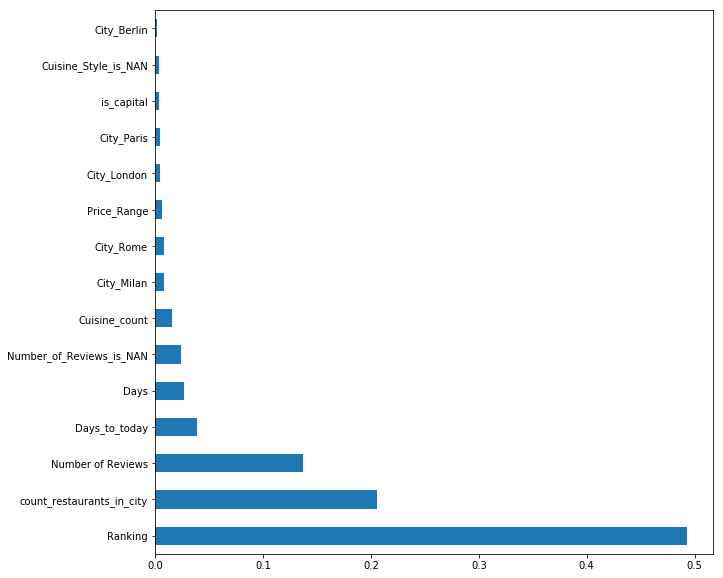

In [110]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [111]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Number_of_Reviews_is_NAN,Cuisine_Style_is_NAN,Cuisine_count,Days,Days_to_today,is_capital,chain restaurants,...,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Price_Range
5980,6595.0,12.0,0.0,0,1,3.0,276.000000,1677.0,0,1,...,0,0,0,0,0,0,0,0,0,2.0
9568,729.0,3.0,0.0,0,1,4.0,123.993124,1375.0,0,1,...,0,0,0,0,0,0,0,0,0,2.0
601,5730.0,68.0,0.0,0,0,2.0,38.000000,1371.0,1,1,...,0,1,0,0,0,0,0,0,0,2.0
5071,1085.0,4.0,0.0,0,0,1.0,123.993124,1579.0,0,1,...,0,0,0,0,0,0,0,0,0,2.0
5940,2193.0,2.0,0.0,0,1,3.0,123.993124,1471.0,0,1,...,0,0,0,0,0,1,0,0,0,2.0
940,1410.0,297.0,0.0,0,0,1.0,95.000000,1652.0,0,1,...,0,0,0,0,0,0,0,0,0,2.0
1411,6059.0,287.0,0.0,0,0,6.0,53.000000,1520.0,1,1,...,0,0,0,0,0,0,0,0,0,2.0
6160,2080.0,4.0,0.0,0,1,3.0,32.000000,1969.0,0,1,...,0,0,0,0,0,1,0,0,0,2.0
8817,2396.0,86.0,0.0,0,0,4.0,18.000000,1408.0,1,0,...,0,0,0,0,1,0,0,0,0,2.0
2577,2523.0,49.0,0.0,0,1,2.0,246.000000,1692.0,1,1,...,0,0,0,0,0,0,0,0,0,2.0


In [112]:
test_data = test_data.drop(['Rating'], axis=1)

In [113]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [114]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [115]:
predict_submission

array([3.045, 4.16 , 4.48 , ..., 3.05 , 4.495, 4.4  ])

In [116]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.045
1,id_1,4.160
2,id_2,4.480
3,id_3,4.310
4,id_4,4.435
5,id_5,4.430
6,id_6,1.835
7,id_7,3.020
8,id_8,3.870
9,id_9,4.705


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
